In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
from gensim.models import Word2Vec

In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
with open('models/TVAE_synthesizer_1.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [4]:
# check out sample
N = 1000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)
#print(sample)

In [5]:
input_columns = ['Purchase Amount', 'Age', 'Account Type_bank_account',
       'Account Type_credit_card', 'Consumer Gender_female',
       'Consumer Gender_male', 'SIC Description_Book Stores',
       'SIC Description_Communications Services, Not Elsewhere Classified',
       'SIC Description_Drug Stores and Proprietary Stores',
       'SIC Description_Eating Places',
       'SIC Description_Family Clothing Stores',
       'SIC Description_Gasoline Service Stations',
       'SIC Description_Grocery Stores', 'SIC Description_Other',
       'SIC Description_Radiotelephone Communications',
       'SIC Description_Taxicabs', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday', 'period_of_month_end',
       'period_of_month_mid', 'period_of_month_start', 'retailerVec_01',
       'retailerVec_02', 'retailerVec_03', 'retailerVec_04', 'retailerVec_05',
       'retailerVec_06', 'retailerVec_07', 'retailerVec_08', 'retailerVec_09',
       'retailerVec_10', 'retailerVec_11', 'retailerVec_12', 'retailerVec_13',
       'retailerVec_14', 'retailerVec_15', 'retailerVec_16', 'retailerVec_17',
       'retailerVec_18', 'retailerVec_19', 'retailerVec_20']

In [6]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
df_sample.head()

,Purchase Amount,Age,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,...,retailerVec_11,retailerVec_12,retailerVec_13,retailerVec_14,retailerVec_15,retailerVec_16,retailerVec_17,retailerVec_18,retailerVec_19,retailerVec_20
0,26.644158,36.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.891212,-1.188423,-0.368426,-1.274239,-0.917882,2.469485,0.214116,1.259863,-0.672904,0.791673
1,4.734209,37.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.633527,0.545909,-0.584883,-2.372888,-0.091175,1.155647,1.801053,0.392917,-0.655558,1.042432
2,8.255201,30.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.050304,0.513940,0.750826,-0.752953,-0.080677,0.195813,0.147831,0.589910,-0.655606,0.327503
3,16.053680,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.097517,0.134185,-0.991358,-3.044562,-1.831410,1.193473,1.058476,2.677326,-1.988640,0.030196
4,30.161914,21.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.644983,-0.038502,0.187672,-0.274052,-0.222291,1.220827,1.751142,0.670913,-2.785171,1.475058


In [28]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # convert selected dataframe to series
    df_output = pd.Series(tmp.columns[np.where(tmp!=0)[1]], name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [29]:
df_num = df_sample.iloc[:,[0,1]]
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [30]:
df_reverse = pd.concat([df_num,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)
#pd.set_option('display.max_rows', N)
df_reverse.head()

,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,26.644158,36.0,credit_card,female,Radiotelephone Communications,NaN,end
1,4.734209,37.0,credit_card,male,Eating Places,NaN,end
2,8.255201,30.0,credit_card,male,Radiotelephone Communications,NaN,NaN
3,16.053680,40.0,bank_account,female,Other,NaN,NaN
4,30.161914,21.0,bank_account,male,Radiotelephone Communications,NaN,NaN


In [10]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]

# load the retailer_map
with open('models/retailer_map.pkl', 'rb') as input:
    retailer_map = pickle.load(input)    

model = Word2Vec.load('models/perSICperPerson.model')
    
# only keep values in the model (more than 5 times appearance)
for key, value in retailer_map.items():
    retailer_map[key] = list(set(value) & set(model.wv.vocab))
    
# group other SIC (after top N) into other
list2keep = ['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Drug Stores and Proprietary Stores', 'Book Stores', 'Family Clothing Stores', 'Taxicabs', 'Radiotelephone Communications', 'Communications Services, Not Elsewhere Classified']
other_list = []    
for key, value in retailer_map.items():
    if key not in list2keep:
        other_list = other_list + value

# delete other group key-values in retailer_map
retailer_map_grouped = {k: retailer_map[k] for k in list2keep}

# add other key-value pairs
retailer_map_grouped['Other'] = other_list

# put retailer vectors into one column
df_retailerVec['retailerVec']= df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_SIC,df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SIC Description,retailerVec
0,Radiotelephone Communications,"[-1.7624265059448363, -0.35074075540486604, 2...."
1,Eating Places,"[-0.9866422981956134, 0.619865349350919, -0.03..."
2,Radiotelephone Communications,"[0.5879243126265042, -0.3643982359175169, -0.0..."
3,Other,"[-0.781215604395978, -0.5573909040059266, 1.80..."
4,Radiotelephone Communications,"[-1.1164830339852982, -0.43022567109488213, -0..."


In [11]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [12]:
df_SIC_vector.loc[174,['SIC Description']].isnull()

SIC Description    False
Name: 174, dtype: bool

In [18]:
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head(10)

,Purchase Amount,Age,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Normalized Retailer
0,26.644158,36.0,credit_card,female,Radiotelephone Communications,NaN,end,Mobilicity
1,4.734209,37.0,credit_card,male,Eating Places,NaN,end,India Village Restaurant
2,8.255201,30.0,credit_card,male,Radiotelephone Communications,NaN,NaN,Digicel
3,16.053680,40.0,bank_account,female,Other,NaN,NaN,Canadian Tire Store
4,30.161914,21.0,bank_account,male,Radiotelephone Communications,NaN,NaN,Koodo Mobile
5,56.586514,30.0,credit_card,female,Eating Places,NaN,NaN,Shawarma Station
6,7.861741,34.0,bank_account,male,Other,NaN,NaN,Staples
7,9.178973,31.0,credit_card,female,Eating Places,NaN,NaN,Topper's Pizza
8,13.658148,31.0,credit_card,female,Eating Places,NaN,NaN,McDonald's
9,10.447851,27.0,bank_account,female,Eating Places,NaN,NaN,McDonald's


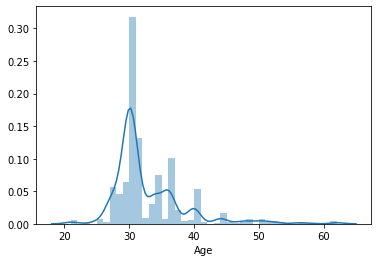

In [14]:
sns.distplot(df_reverse['Age']);

In [15]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [16]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts  Per (%)
0  bank_account     553     55.3
1   credit_card     447     44.7


Consumer Gender
  Consumer Gender  Counts  Per (%)
0          female     619     61.9
1            male     381     38.1


Normalized Retailer
          Normalized Retailer  Counts  Per (%)
138              Koodo Mobile      52      5.2
294            Super Save Gas      41      4.1
78                    Digicel      41      4.1
311               Tim Hortons      26      2.6
184                Mobilicity      26      2.6
..                        ...     ...      ...
148                      Lidl       1      0.1
150              Little India       1      0.1
151             Little Saigon       1      0.1
152  Little Short Stop Stores       1      0.1
341                     Zehrs       1      0.1

[342 rows x 3 columns]


SIC Description
                                     SIC Description  Counts  Per (%)
3                                      Eating Places     281     28

barplot for SIC Description


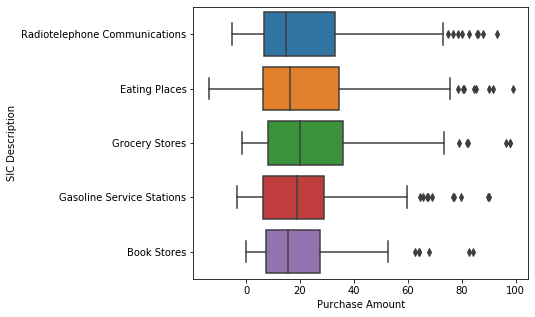

barplot for Normalized Retailer


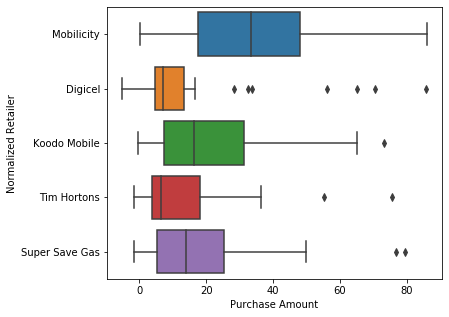

In [17]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df_reverse[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount'] < threshold)]
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount'])
    plt.show()